### Vorticity-Streamfunction Equations Solver
#### Homework 1, AMATH 581
#### Anna Dodson
#### Nov 22, 2024

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.fft import fft2, ifft2, fftfreq
from scipy.integrate import solve_ivp
from scipy.sparse.linalg import bicgstab, gmres, splu, spsolve
from scipy.linalg import lu, solve_triangular
from matplotlib.animation import FuncAnimation
import time

# Define parameters
nu = 0.001

x_min, x_max, n = -10, 10, 64
x = np.linspace(x_min, x_max, n + 1)
x = x[:n]
y = np.linspace(x_min, x_max, n + 1)
y = y[:n]
dx = (x_max - x_min) / n
dy = dx
X, Y = np.meshgrid(x, y)

t_min, t_max, dt = 0, 4, .5
n_t = int((t_max-t_min)/dt) 
tspan = np.linspace(t_min, t_max, n_t + 1)
# Define spatial domain and initial conditions
a = 1 # divisor in the x direction
b = 20 # divisor in the y direction
w0 = np.exp(-X**2 / a - Y**2 / b) + 1j * np.zeros((n, n))  # Initialize as complex; technically not a 4:1 aspect for this lol

# Define spectral k values
kx = (np.pi / x_max) * np.concatenate((np.arange(0, n/2), np.arange(-n/2, 0)))
kx[0] = 10e-6
ky = (np.pi / x_max) * np.concatenate((np.arange(0, n/2), np.arange(-n/2, 0)))
ky[0] = 10e-6
KX, KY = np.meshgrid(kx, ky)


/var/folders/6t/1zzcrm290x3_hj_335bbjsqr0000gn/T/ipykernel_203/2410420486.py:28: UserWarning: shading value 'interp' not in list of valid values ['gouraud', 'nearest', 'flat', 'auto']. Setting shading='auto'.
  plt.pcolor(x, y, w, shading='interp')


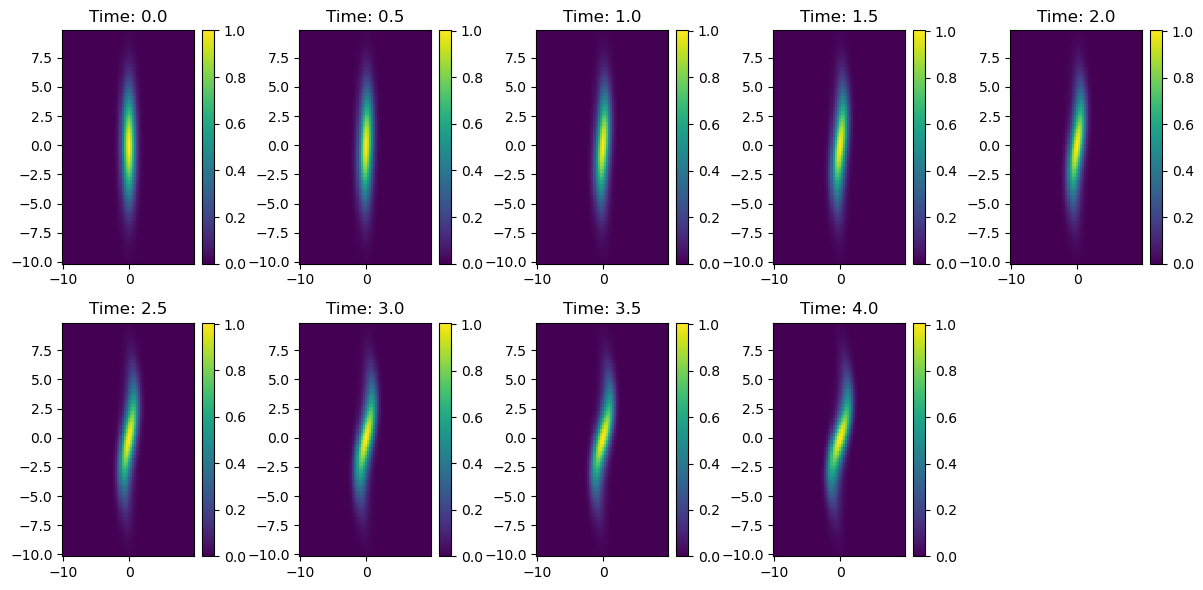

(4096, 9)


In [2]:
# Nathan's code for using FFT for the complete solve.
# Define the ODE system
def spc_rhs(t, w_hat2, n, KX, KY, nu):
    n2 = n*n
    w_hatc = w_hat2[0:n2] + 1j*w_hat2[n2:]
    w_hat = w_hatc.reshape((n, n)) 
    psi_hat = w_hat / (KX**2 + KY**2) # we determined this in class 
    psix = np.real(ifft2(1j * KX * psi_hat))
    psiy = np.real(ifft2(1j * KY * psi_hat))
    wx = np.real(ifft2(1j * KX * w_hat))
    wy = np.real(ifft2(1j * KY * w_hat))
    rhs = (nu * (KX**2 + KY**2) * w_hat + fft2(wx * psiy - wy * psix)).reshape(n2) # still in the fourier domain
    return np.hstack([np.real(rhs),np.imag(rhs)])

# Solve the ODE and plot the results
n2 = n*n
w_hat0 = np.hstack([np.real(fft2(w0).reshape(n2)),np.imag(fft2(w0).reshape(n2))])
t_span = (tspan[0], tspan[-1])
w_hatsol = solve_ivp(spc_rhs, t_span, w_hat0, t_eval=tspan, args=(n, KX, KY, nu)).y.T 

w_real_solution = []
plt.figure(figsize=(12, 6))
for j, t in enumerate(tspan):
    wc = w_hatsol[j,:n2].reshape((n, n))
    w = np.real(ifft2(wc))
    w_real_solution.append(w.reshape(n2))
    plt.subplot(2, 5, j + 1)
    plt.pcolor(x, y, w, shading='interp')
    plt.title(f'Time: {t}')
    plt.colorbar()

plt.tight_layout()
plt.show()

w_sol_a1 = np.stack(w_real_solution).T # gradescope expects (4096, 9)
print(w_sol_a1.shape)

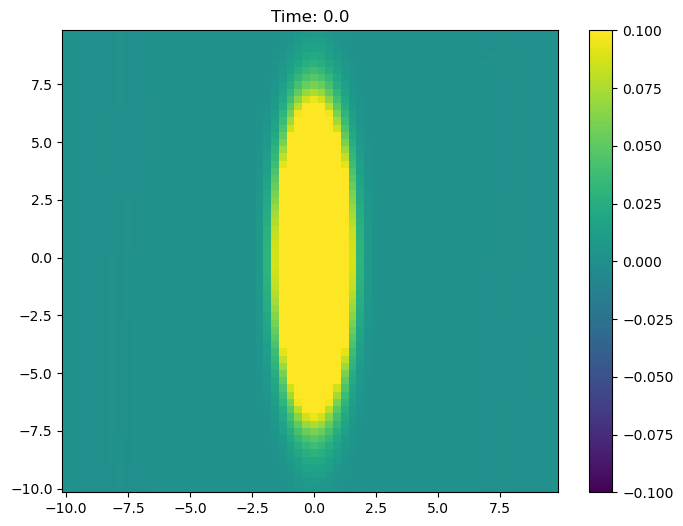

In [3]:
# Part A animation
import matplotlib.animation as animation
# %matplotlib qt

# Create the figure and initial plot
fig, ax = plt.subplots(figsize=(8, 6))
pcolor = ax.pcolor(x, y, np.zeros((n, n)), shading='auto', cmap='viridis')
colorbar = plt.colorbar(pcolor, ax=ax)
title = ax.set_title("Time: 0.0")

# Update function for animation
def update(frame):
    t = tspan[frame]
    wc = ifft2(w_hatsol[frame, :n2].reshape((n, n)))
    w = np.real(wc)
    pcolor.set_array(w.ravel())  # Update data
    title.set_text(f"Time: {t}")
    return pcolor, title

# Create the animation
ani = animation.FuncAnimation(
    fig, update, frames=len(tspan), interval=500, blit=True
)

# Save or display the animation
plt.show()

In [4]:
from scipy.sparse import spdiags, csc_matrix


# A, B and C from HW4
#A
def get_A_matrix(m, dx): # N value in x and y directions
    n = m * m  
    e0 = np.zeros((n, 1))  # vector of zeros
    e1 = np.ones((n, 1))   # vector of ones
    e2 = np.copy(e1)    # copy the one vector
    e4 = np.copy(e0)    # copy the zero vector

    for j in range(1, m+1):
        e2[m*j-1] = 0  # overwrite every m^th value with zero
        e4[m*j-1] = 1  # overwirte every m^th value with one

    # Shift to correct positions
    e3 = np.zeros_like(e2)
    e3[1:n] = e2[0:n-1]
    e3[0] = e2[n-1]

    e5 = np.zeros_like(e4)
    e5[1:n] = e4[0:n-1]
    e5[0] = e4[n-1]

    # Place diagonal elements
    diagonals = [e1.flatten(), e1.flatten(), e5.flatten(), 
                e2.flatten(), -4 * e1.flatten(), e3.flatten(), 
                e4.flatten(), e1.flatten(), e1.flatten()]
    offsets = [-(n-m), -m, -m+1, -1, 0, 1, m-1, m, (n-m)]

    matA = spdiags(diagonals, offsets, n, n).toarray()
    return csc_matrix((1/dx**2)*matA)

def get_B_matrix(m, dx):
    n = m * m  

    #B - dy matrix
    # Constructing matrix B for ∂y using finite differences with periodic boundaries
    e1 = np.ones((n, 1))
    e2 = np.ones((m, 1))
    diagonals_dy = [-e1.flatten(), e1.flatten(), e1.flatten(), -e1.flatten()]
    offsets_dy = [-m, m, -(n-m), n-m]  # Shifts in y direction
    matB = spdiags(diagonals_dy, offsets_dy, n, n).toarray()
    return csc_matrix((1/(2*dx))*matB)

def get_C_matrix(m, dx): 
    n = m * m  
    # Constructing matrix C for ∂x using finite differences with periodic boundaries
    # Set wrap-around connections to zero initially
    e_wrap1 = np.ones(n)  # for wrap-around connections
    e_wrap2 = np.ones(n)  # for wrap-around connections
    for i in range(1, m):
        e_wrap1[m * i] = 0  # Avoid unwanted connections across row ends
        e_wrap2[m * i - 1] = 0  # Avoid unwanted connections across row ends
    diagonals_dx = [-e_wrap2.flatten(), e_wrap1.flatten(), ]
    offsets_dx = [-1, 1]  # Shifts in x direction

    matC = spdiags(diagonals_dx, offsets_dx, n, n).toarray()
    for i in range(m):
        # Set periodic connections at row ends for each block row
        matC[i * m, (i + 1) * m - 1] = -1  # Left boundary wraps to right
        matC[(i + 1) * m - 1, i * m] = 1    # Right boundary wraps to left
    return csc_matrix((1/(2*dx))*matC)

In [5]:
# Here is our numerical integration approach
# We must satisfy CFL conditions, recall ωt +[ψ,ω]=ν∇2ω and ∇2ψ = ω and [ψ, ω] = ψxωy − ψyωx
# so, w_t = nu*A*psi - [psi,w] = nu*A*psi - ψxωy + ψyωx = nu*A*psi  - C*x * B*w + C*w + B*x
# Now we're going to use some numerical approaches. 

# used to get w from w_prev and psi
def rhs(t, w, streamline_rhs, A, B, C):
    psi = streamline_rhs(w, A)
    diffusive_term = nu * (A @ psi)
    winds_term = (B @ w) * (C @ psi) - (C @ w) * (B @ psi)
    rhs = diffusive_term - winds_term
    return rhs



In [6]:
# Main loops for running the solver and plotting it
w0_stacked = np.hstack([np.real(w0.reshape(n2))])
dx = ( x_min - x_max ) / n

def run_time_forward(streamline_rhs, w0, n, dx):
    w_sol = []
    # In ivp_solve, this uses psi to get w_next
    A = get_A_matrix(n, dx)
    B = get_B_matrix(n, dx)
    C = get_C_matrix(n, dx)
    start_time = time.time()  # Record the start time
    w_sol = solve_ivp(rhs, t_span, w0, t_eval=tspan, args=(streamline_rhs, A, B, C)).y
    end_time = time.time()  # Record the end time
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.2f} seconds")
    return w_sol, elapsed_time


def plot_time_evolution(w_real_matrix, tspan, title, show_centers=False):
    def find_vortex_center(w):
        max_idx = np.unravel_index(np.argmax(w), w.shape)
        return max_idx
    fig, axes = plt.subplots(1, len(tspan), figsize=(20, 4), constrained_layout=True)

    for j, t in enumerate(tspan):
        w = w_real_matrix[:, j].reshape((n, n))
        ax = axes[j]
        im = ax.pcolor(X, Y, w, shading='auto', cmap='RdBu_r')
        if show_centers:
            center = find_vortex_center(w)
            ax.scatter(X[center[0], center[1]], Y[center[0], center[1]], color="black", label="Vortex Center")
        ax.set_title(f'Time: {t:.2f}')

    fig.suptitle(title)
    cbar = fig.colorbar(im, ax=axes.ravel().tolist(), shrink=0.95)
    cbar.set_label("Vorticity")
    plt.show()


/Users/annadodson/anaconda3/lib/python3.11/site-packages/scipy/integrate/_ivp/base.py:23: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(fun(t, y), dtype=dtype)


Elapsed time: 0.01 seconds


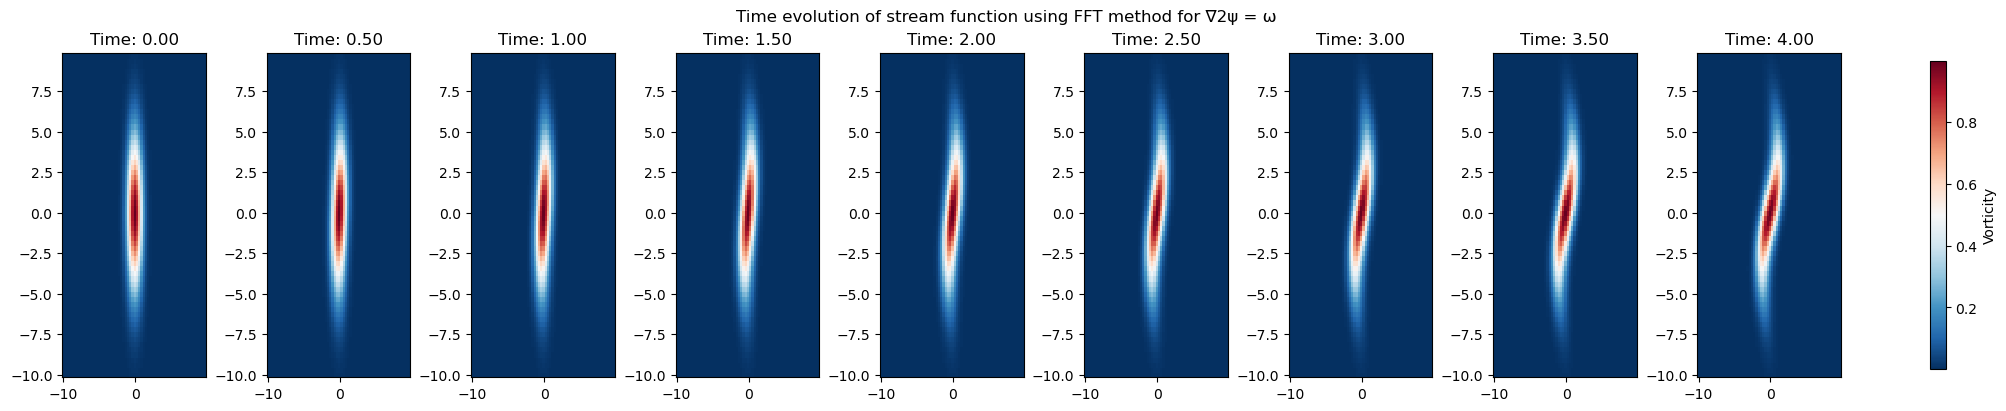

(4096, 9)


In [7]:
def fft_streamline_rhs(w, A):
    w_recovered = w.reshape((n, n)) + 1j * np.zeros((n, n))
    n2 = n*n
    w_c_stacked = np.hstack([np.real(fft2(w_recovered).reshape(n2)), np.imag(fft2(w_recovered).reshape(n2))])
    w_hatc = w_c_stacked[0:n2] + 1j*w_c_stacked[n2:]
    w_hat = w_hatc.reshape((n, n)) # this is in the fourier domain
    psi_hat = w_hat / (KX**2 + KY**2) # we determined this in class 
    return ifft2(psi_hat).reshape(n2)

w_sol_fft, t1 = run_time_forward(fft_streamline_rhs, w0_stacked, n, dx)
plot_time_evolution(w_sol_fft, tspan, title="Time evolution of stream function using FFT method for ∇2ψ = ω")
print(w_sol_fft.shape)
A1 = w_sol_fft

Elapsed time: 0.80 seconds


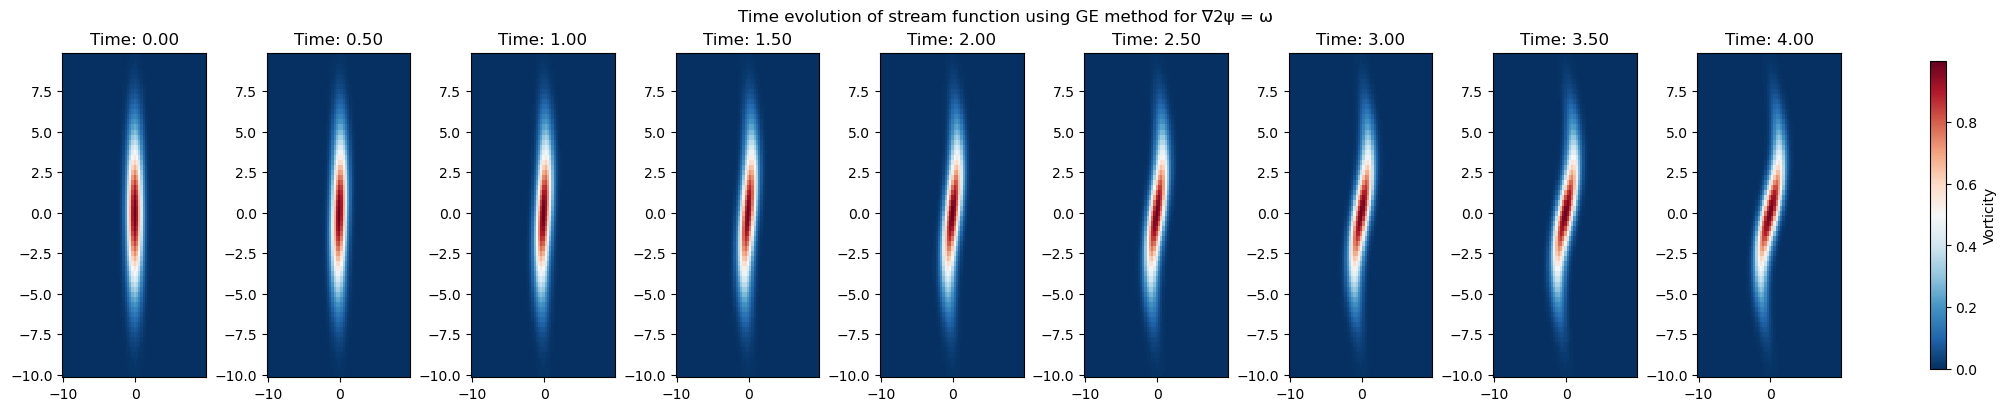

(4096, 9)


In [8]:
# gaussian elimination for stream function
# Just solving ∇2ψ = ω, we then have that A x = b -> use w_current to get psi using A matrix
# under the hood: A \ b = x
def ge_streamline_rhs(w, A):
    A[0,0] = 2 # to fix singular matrix
    psi = spsolve(A, -w)
    return psi

w_sol_ge, t2 = run_time_forward(ge_streamline_rhs, w0_stacked, n, dx)
plot_time_evolution(w_sol_ge, tspan, title="Time evolution of stream function using GE method for ∇2ψ = ω")
print(w_sol_ge.shape)
A2 = w_sol_ge

Elapsed time: 0.79 seconds


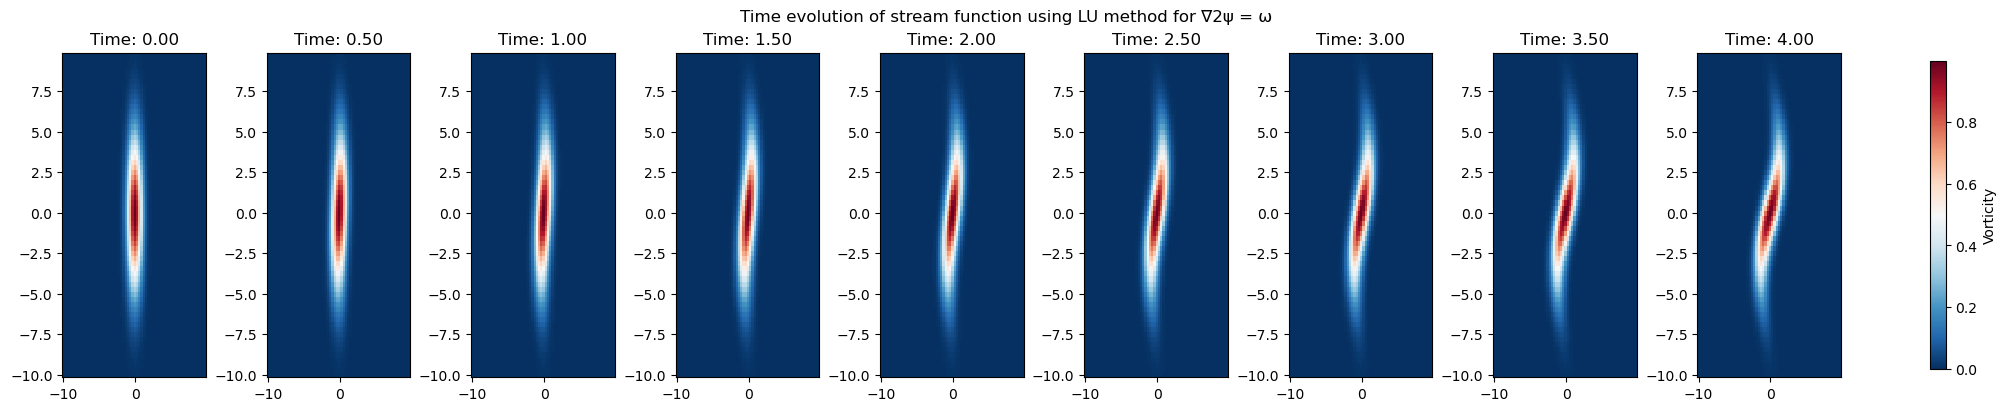

(4096, 9)


In [9]:
# lu decomposition for stream function
# Just solving ∇2ψ = ω, we then have that A x = b -> use w_current to get psi using A matrix
# under the hood:
#U_A * y = x
#L_A * x = b
# y = w \ U_A
# x = y \ L_A 
def lu_streamline_rhs(w, A):
    A[0,0] = 2 # to fix singular matrix
    lu = splu(A)
    psi = lu.solve(-w)
    return psi

w_sol_lu, t3 = run_time_forward(lu_streamline_rhs, w0_stacked, n, dx)
plot_time_evolution(w_sol_lu, tspan, title="Time evolution of stream function using LU method for ∇2ψ = ω")
print(w_sol_lu.shape)
A3 = w_sol_lu

Elapsed time: 2.21 seconds


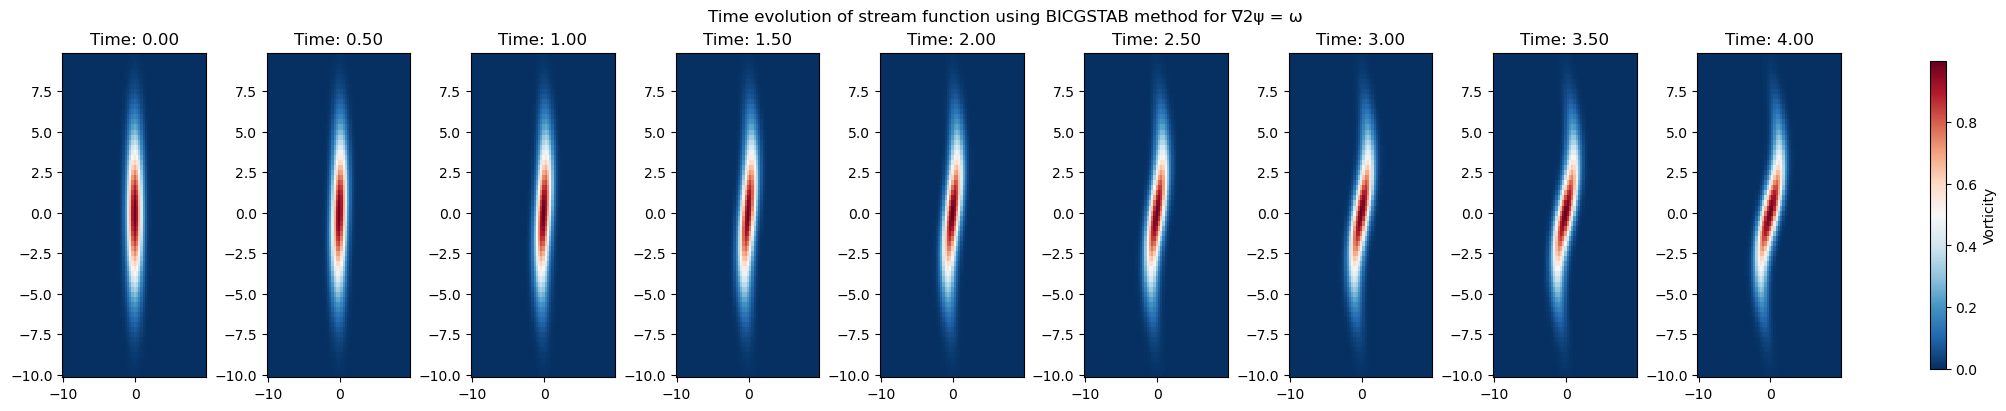

(4096, 9)


In [10]:
# BICGSTAB for stream function
# Just solving ∇2ψ = ω, we then have that A x = b -> use w_current to get psi using A matrix
# under the hood:
def bigcstab_streamline_rhs(w, A):
    A[0,0] = 2 # to fix singular matrix
    bicgpsi, info = bicgstab(A, -w)
    assert info == 0
    return bicgpsi

w_sol_bicg, t4 = run_time_forward(bigcstab_streamline_rhs, w0_stacked, n, dx)
plot_time_evolution(w_sol_bicg, tspan, title="Time evolution of stream function using BICGSTAB method for ∇2ψ = ω")
print(w_sol_bicg.shape)
A4 = w_sol_bicg

Elapsed time: 71.69 seconds


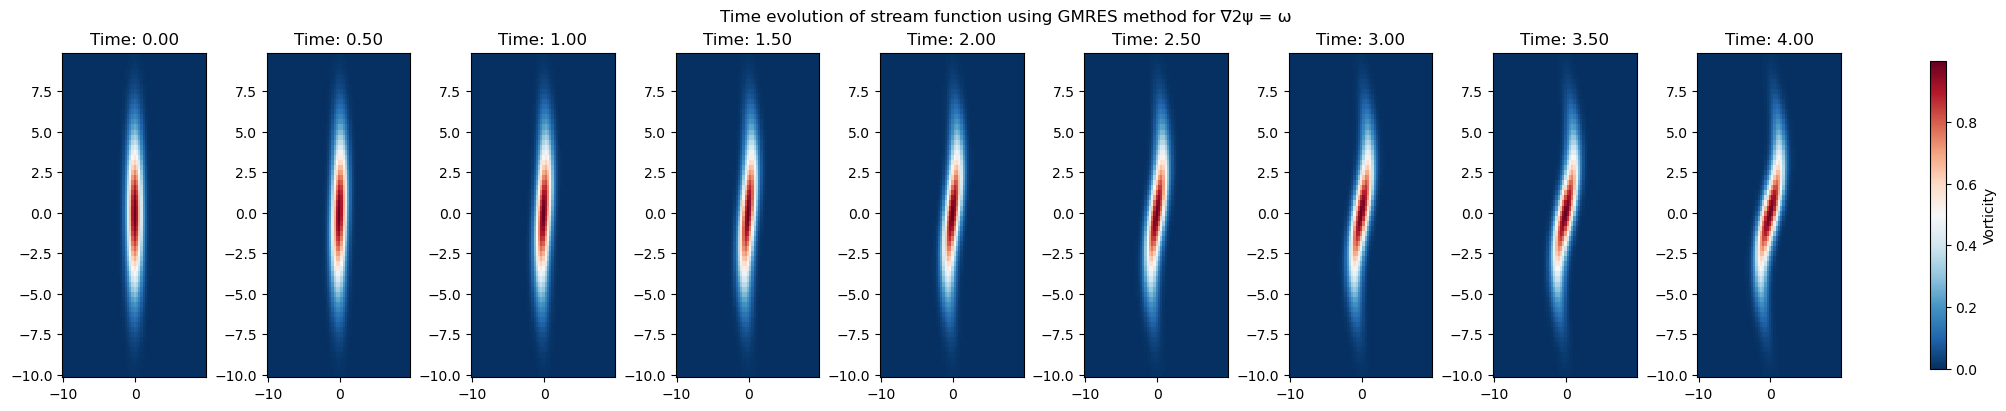

(4096, 9)


In [11]:
# GMRES for stream function
# Just solving ∇2ψ = ω, we then have that A x = b -> use w_current to get psi using A matrix
# under the hood:
def gmres_streamline_rhs(w, A):
    A[0,0] = 2 # to fix singular matrix
    psi, info = gmres(A, -w)
    assert info == 0
    return psi

w_sol_gmres, t5 = run_time_forward(gmres_streamline_rhs, w0_stacked, n, dx)
plot_time_evolution(w_sol_gmres, tspan, title="Time evolution of stream function using GMRES method for ∇2ψ = ω")
print(w_sol_gmres.shape)
A5 = w_sol_gmres

##### Comparison of times

We have seen that some of the methods take a lot longer than others, even on the small grid (64x64). The fastest method was FFT by a long shot, however this method can only be used in a case where the problem has periodic boundary conditions (or zero BC at infinity)

* FFT: 0.01 seconds 
* GE (spsolve): ~0.75 seconds
* LU (splu): ~0.76 seconds
* BICGSTAB: ~2 seconds
* GMRES: ~70 seconds


In [12]:
# # Now let's use some of these methods in novel scenarios:
# # 1. Two oppositely “charged” Gaussian vorticies next to each other, i.e. one with positive amplitude, the other with negative amplitude.

# # Since these are linear 2nd order systems, we can superimpose the solutions for each vortex separately.
# # Let's put one centered at (-1, 0) and the other at (1, 0).

# w0_left = np.exp(-(X+1)**2 / a - Y**2 / b) + 1j * np.zeros((n, n))  # Initialize as complex; technically not a 4:1 aspect for this lol
# w0_right = - np.exp(-(X-1)**2 / a - Y**2 / b) + 1j * np.zeros((n, n))  # Initialize as complex; technically not a 4:1 aspect for this lol
# w0_left_stacked = np.hstack([np.real(w0_left.reshape(n2))])
# w0_right_stacked = np.hstack([np.real(w0_right.reshape(n2))])
# w0_2poles_stacked = w0_left_stacked + w0_right_stacked
# dx = ( x_min - x_max ) / n

# w_sol_2poles_fft, t1 = run_time_forward(fft_streamline_rhs, w0_2poles_stacked, n, dx)
# plot_time_evolution(w_sol_2poles_fft, tspan, title="Time evolution of 2 gaussian vortices using FFT method for ∇2ψ = ω")
# print(w_sol_2poles_fft.shape)

In [13]:
# # Now we can write a function to handle the rest of the cases for us.
# # Same superposition concept applies; add Gaussian vortices to w0, the initial condition

# def gaussian_vortex(X, Y, x0, y0, amplitude, sigma_x, sigma_y):
#     """Define a Gaussian vortex."""
#     return amplitude * np.exp(-((X - x0)**2 / (2 * sigma_x**2) + (Y - y0)**2 / (2 * sigma_y**2)))

# # Define initial conditions
# def initial_conditions(case, n_vortices=10):
#     w0 = np.zeros_like(X, dtype=np.complex128)
#     if case == "opposite_charged":
#         w0 += gaussian_vortex(X, Y, -1, 0, 1, 2, 2)
#         w0 += gaussian_vortex(X, Y, 1, 0, -1, 2, 2)
#     elif case == "same_charged":
#         w0 += gaussian_vortex(X, Y, -1, 0, 1, 2, 2)
#         w0 += gaussian_vortex(X, Y, 1, 0, 1, 2, 2)
#     elif case == "colliding_pairs":
#         w0 += gaussian_vortex(X, Y, -1, 1, 1, 2, 2)
#         w0 += gaussian_vortex(X, Y, 1, -1, -1, 2, 2)
#         w0 += gaussian_vortex(X, Y, 1, 1, -1, 2, 2)
#         w0 += gaussian_vortex(X, Y, -1, -1, 1, 2, 2)
#     elif case == "random_vortices":
#         np.random.seed(42)  # For reproducibility
#         for _ in range(n_vortices):
#             x0, y0 = np.random.uniform(x_min, x_max, size=2)
#             amplitude = np.random.uniform(-1, 1)
#             sigma_x, sigma_y = np.random.uniform(1, 3, size=2)
#             w0 += gaussian_vortex(X, Y, x0, y0, amplitude, sigma_x, sigma_y)
#     else:
#         raise ValueError("Unknown initial condition case")
#     return w0

# # Test different cases
# cases = ["opposite_charged", "same_charged", "colliding_pairs", "random_vortices"]
# case_solutions = []
# for case in cases:
#     w0 = initial_conditions(case, n_vortices=15)
#     # Solve the equations with the new w0
#     w0_stacked = np.hstack([np.real(w0.reshape(n2))])

#     w_sol_fft, ts = run_time_forward(fft_streamline_rhs, w0_stacked, n, dx)
#     plot_time_evolution(w_sol_fft, tspan, title=f"Time evolution of {case}, FFT method")

#     # Plot results
#     case_solutions.append(w_sol_fft) # 2d array of solutions at time points, to make nice movies

In [14]:
# # Now, we'll increase the time scale to make a really cool movie! 

# # Define parameters
# nu = 0.001
# x_min, x_max, n = -10, 10, 256
# n2 = n*n
# x = np.linspace(x_min, x_max, n + 1)
# x = x[:n]
# y = np.linspace(x_min, x_max, n + 1)
# y = y[:n]
# dx = (x_max - x_min) / n
# dy = dx
# X, Y = np.meshgrid(x, y)

# t_min, t_max, dt = 0, 10, .05
# n_t = int((t_max-t_min)/dt) 
# tspan = np.linspace(t_min, t_max, n_t + 1)
# t_span = (tspan[0], tspan[-1])

# # Define spatial domain and initial conditions
# a = 1 # divisor in the x directtion
# b = 20 # divisor in the y direction
# w0 = np.exp(-X**2 / a - Y**2 / b) + 1j * np.zeros((n, n))  # Initialize as complex; technically not a 4:1 aspect for this lol

# # Define spectral k values
# kx = (np.pi / x_max) * np.concatenate((np.arange(0, n/2), np.arange(-n/2, 0)))
# kx[0] = 10e-6
# ky = (np.pi / x_max) * np.concatenate((np.arange(0, n/2), np.arange(-n/2, 0)))
# ky[0] = 10e-6
# KX, KY = np.meshgrid(kx, ky)

# cases = ["opposite_charged", "same_charged", "colliding_pairs", "random_vortices"]
# case_solutions = []
# for case in cases:
#     w0 = initial_conditions(case, n_vortices=15)
#     # Solve the equations with the new w0
#     w0_stacked = np.hstack([np.real(w0.reshape(n2))])

#     w_sol_fft, ts = run_time_forward(fft_streamline_rhs, w0_stacked, n, dx)
#     #plot_time_evolution(w_sol_fft, tspan, title=f"Time evolution of {case}, FFT method")

#     # Plot results
#     case_solutions.append(w_sol_fft) # 2d array of solutions at time points, to make nice movies



In [15]:
# print(len(case_solutions))
# print(n2)
# print(case_solutions[0].shape)

In [16]:
# # Generating the movie
# import matplotlib.animation as animation
# # COMMENT OUT BECAUSE GRADESCOPE HATES ME
# %matplotlib qt 

# for case, w_sol_fft in enumerate(case_solutions):
#     # Create the figure and initial plot
#     fig, ax = plt.subplots(figsize=(8, 6))
#     pcolor = ax.pcolor(x, y, np.zeros((n, n)), shading='auto', cmap='viridis')
#     colorbar = plt.colorbar(pcolor, ax=ax)
#     title = ax.set_title("Time: 0.0")

#     # Update function for animation
#     def update(frame):
#         t = tspan[frame]
#         w = w_sol_fft[:n2, frame].reshape((n, n))
#         pcolor.set_array(w.ravel())  # Update data
#         title.set_text(f"Time: {t}")
#         return pcolor, title

#     # Create the animation
#     ani = animation.FuncAnimation(
#         fig, update, frames=len(tspan), interval=500, blit=True
#     )
#     ani.save(f'{cases[case]}.gif', writer='ffmeg', fps=60)


# # Save or display the animation
# plt.show()